<a href="https://colab.research.google.com/github/alicebeth-m/VEGA/blob/main/Vega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование продаж в магазинах офлаин-ритейлера в США

Импортируем необходимые для работы библиотеки.

In [ ]:
!pip install pmdarima
!pip install sktime

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pmdarima as pm
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.trend import STLForecaster
from sktime.forecasting.naive import NaiveForecaster, NaiveVariance
from pmdarima import model_selection
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(level=logging.CRITICAL)

In [ ]:
#основные данные
sales = pd.read_csv('shop_sales.csv')
stores = list(sales.store_id.unique())
print(f'Все магазины: {stores}')
sales.head()

Все магазины: ['STORE_2', 'STORE_3', 'STORE_1']


,item_id,store_id,date_id,cnt
0,STORE_2_085,STORE_2,1,3
1,STORE_2_085,STORE_2,2,8
2,STORE_2_085,STORE_2,3,0
3,STORE_2_085,STORE_2,4,3
4,STORE_2_085,STORE_2,5,0


Для анализа возьмём магазин №2 и посмотрим, какие данные там находятся.

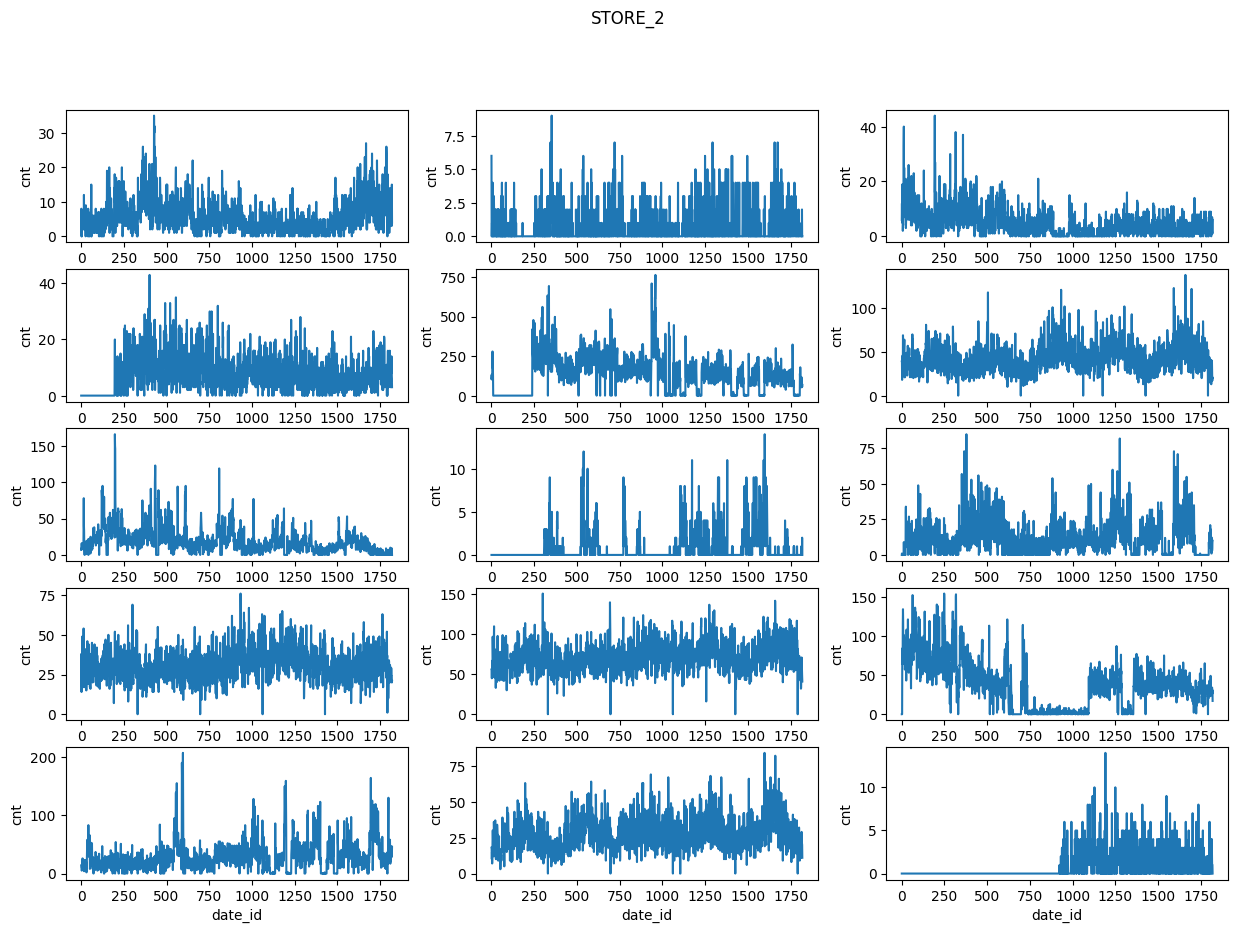

In [ ]:
fig,ax = plt.subplots(5,3,figsize=(15,10))

for i, art in enumerate(sales[sales.store_id=='STORE_2'].item_id.unique()):
    sns.lineplot(data = sales[(sales.item_id==art) & (sales.store_id=='STORE_2')],
                 x='date_id',y='cnt',ax = ax[i//3][i%3])
plt.suptitle("STORE_2");

In [ ]:
store2 = sales[sales.store_id=='STORE_2'].drop(['store_id'], axis=1)

In [ ]:
store2.head()

,item_id,date_id,cnt
0,STORE_2_085,1,3
1,STORE_2_085,2,8
2,STORE_2_085,3,0
3,STORE_2_085,4,3
4,STORE_2_085,5,0


Видим, что data_id необходимо сопоставить конкретные данные, так что понадобится еще файл shop_sales_dates.csv.

In [ ]:
calendar = pd.read_csv('shop_sales_dates.csv')
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,date_id,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3
0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,1,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,2,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,3,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,4,0,1,1
4,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,5,1,1,0


После того, как мы разобрались с тем, какие данные необходимы, импортируем предварительно написанный класс содержащий функции для работы с рядом.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pmdarima as pm
from collections import defaultdict
from sktime.split import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from IPython.display import display


class Solution():
    def init(self, store, calendar, periods, models):
        self.store = store
        self.calendar = calendar
        self.models = models
        self.periods = periods
        self.metrics = None

    def preprocess_data(self):
        self.store = self.store.join(
            self.calendar[['date_id', 'date']].set_index('date_id'),
            on='date_id')
        self.store['date'] = pd.to_datetime(self.store['date'])
        self.products = {}
        for art in self.store.item_id.unique():
            self.products[art] = self.store[self.store.item_id == art].drop(
                ['item_id', 'date_id'], axis=1).set_index('date')
            self.products[art].index = pd.PeriodIndex(
                self.products[art].index,
                freq='D')
        return self.products.keys()

    def train_model(self):
        metrics = defaultdict(lambda: defaultdict(int))
        for period in tqdm(self.periods, desc='period'):
            for name_product, product in tqdm(
                self.products.items(),
                desc='product'
            ):
                n_splits = product.shape[0] // (period + 1)
                h = product.shape[0]//(n_splits + 1)
                M = defaultdict(list)  # для метрик
                if period == 1:
                    window_length = 270
                elif period == 7:
                    window_length = 270
                else:
                    window_length = 270
                splitter = SlidingWindowSplitter(
                    fh=np.arange(1, period + 1),
                    window_length=window_length,
                    step_length=150)
                for idx_train, idx_test in tqdm(
                    list(splitter.split(product)),
                    desc='cross-validation'
                ):
                    train = product.iloc[idx_train].values
                    test = product.iloc[idx_test].values
                    for name, model in self.models.items():
                        model.fit(train)
                        fh = np.arange(1, period + 1)
                        pred = model.predict(fh)
                        M[name].append(self.metrics_report(test, pred))
                metrics[period][name_product] = M
        self.metrics = metrics
        return metrics

    def metrics_report(self, y_true, y_pred):
        res = {
            'mae': mean_absolute_error(y_true, y_pred),
            'mape': mean_absolute_percentage_error(y_true, y_pred),
            'r2': r2_score(y_true, y_pred)
        }
        return res

    def predict(self, product, period, model_name):
        y_train, y_test = temporal_train_test_split(
            self.products[product],
            test_size=period,
            train_size=270)
        forecaster = self.models[model_name]
        forecaster.fit(y_train)
        fh = ForecastingHorizon(y_test.index)
        y_pred = forecaster.predict(fh=fh)
        plot_series(
            y_test,
            y_pred,
            y_train,
            labels=["y_test", "y_pred", "y_train"],
            title=f'{product}+{model_name}')
        return y_pred

    def display_metrics(self):
        metrics = self.metrics
        for period in metrics.keys():
            print(f'Период = {period} дней')
            print()
            period_data_mae = {}
            period_data_mape = {}
            for product in metrics[period].keys():
                for model in metrics[period][product].keys():
                    mae = []
                    mape = []
                    for d in metrics[period][product][model]:
                        mae.append(d['mae'])
                        mape.append(d['mape'])
                    mean_mae = np.array(mae).mean()
                    mean_mape = np.array(mape).mean()
                    if model not in period_data_mae.keys():
                        period_data_mae[model] = []
                    if model not in period_data_mape.keys():
                        period_data_mape[model] = []
                    period_data_mae[model].append(mean_mae)
                    period_data_mape[model].append(mean_mape)
            df_mae = pd.DataFrame(
                data=period_data_mae,
                index=metrics[period].keys())
            df_mape = pd.DataFrame(
                data=period_data_mape,
                index=metrics[period].keys())
            print("метрика MAE")
            display(df_mae)
            print()
            print('метрика MAPE')
            display(df_mape)
            print()


Класс содержит 5 функций:

1) preprocess_data() - для предобработки данных: выделяет из всего датасета данные, принадлежащие каждому из 15 продуктов, и делит на 15 отдельных временных рядов, соотносит 2 датафрейма с продуктами и календарем по  date и data_id, затем даты из типа object переводит в тип datetime, так как большинство моделей работают именно с этим типом данных, в конце функция удаляет лишние столбцы с индексами из изначальных датафреймов.

2) Функция train_model() нужна для подсчета метрик, в ней реализована кросс-валидация со скользящим окном постоянного размера.

3) Функция metrics_report() нужна для непосредственного вычисления метрик между предсказанными значениями и истинными. Функция возвращает и сохраняет в классе значения метрик MAE, MAPE, R2. В качестве метрик были выбраны именно они так, как MAE менее чувствительна к выбросам по сравнению с другими метриками, такими как MSE, но при этом она проста в реализации и наглядно показывает среднюю величину ошибки в тех же единицах, что и данные. MAPE также простая для интерпретации и позволяет сравнивать качество прогнозов для различных наборов данных или моделей. Важно учесть, что MAPE не работает для рядов с нулями, но тем не менее она позволит оценить работу моделей на остальных рядах. Метрика R2 менее наглядная, но тоже позволяет оценить, насколько хорошо модель подходит для конкретных данных.

4) Функция predict() принимает на вход параметры product, period, model_name и выдаёт предсказания по конкретным данным для заданного периода, артикула товара и модели.

5) Функция display_metrics() нужна для наглядной демонстрации значений получившихся метрик, для сравнения и оценки результатов модели.

In [ ]:
forecaster = NaiveForecaster(strategy='mean', sp=91)
naive = NaiveVariance(forecaster)

stl = STLForecaster(sp=91, seasonal_deg=1)

prophet = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative', alpha=0.7)

models = {
    'naive': naive,
    'stl': stl,
    'prophet': prophet,
}

В качестве моделей возьмем NaiveForecaster, STLForecaster и Prophet:

NaiveForecaster - чтобы ради интереса посмотреть, насколько данный ряд можно предсказать наивным прогнозом в виде среднего значения у чисел, взятых с определенной периодичностью (периодичность подобрана из графиков). STL - так как она позволяет выделить из данных сезонность и тренд, а у некоторых продуктов определенно наблюдается сезонность, судя по графикам выше. Также STL достаточно устойчива к выбросам, что позволит ей не так сильно "ломаться", когда она встретит длительные нулевые данные. При этом STL хорошо анализирует остатки ряда, что полезно в случаях, когда данные имеют необычные зависимости. Модель Prophet была выбрана, так как она хорошо работает с данными, содержащими сезонность и сильно нелинейную зависимость, а также с данными с пропусками (или имеющими длительные нулевые значения).

Посчитаем метрики MAE и MAPE для этих моделей на каждом из трех периодов: неделя, месяц, квартал.

In [ ]:
periods = [7, 30, 92]
s = Solution(store2, calendar, periods, models)
s.preprocess_data()
metrics = s.train_model()
s.display_metrics()

period:   0%|          | 0/3 [00:00<?, ?it/s]

product:   0%|          | 0/15 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

product:   0%|          | 0/15 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/11 [00:00<?, ?it/s]

product:   0%|          | 0/15 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

cross-validation:   0%|          | 0/10 [00:00<?, ?it/s]

Период = 7 дней

метрика MAE


,naive,stl,prophet
STORE_2_085,3.893939,3.656060,3.653862
STORE_2_043,1.281385,1.378728,0.989157
STORE_2_054,3.478355,3.445086,3.032425
STORE_2_325,5.002165,4.935514,4.671779
STORE_2_090,76.945887,86.446868,72.728529
STORE_2_252,12.281385,16.325440,15.088824
STORE_2_376,12.450216,13.491915,12.165233
STORE_2_391,1.558442,1.942930,1.111708
STORE_2_524,11.402597,10.118585,8.832982
STORE_2_555,7.218615,9.368356,7.594744



метрика MAPE


,naive,stl,prophet
STORE_2_085,1.588932e+15,7.896553e+14,6.274405e+14
STORE_2_043,2.495501e+15,2.514685e+15,1.895761e+15
STORE_2_054,3.743252e+15,3.568527e+15,3.411348e+15
STORE_2_325,1.569436e+15,1.784156e+15,1.954453e+15
STORE_2_090,6.461983e+16,7.654923e+16,8.651089e+16
STORE_2_252,2.534493e+15,2.727048e+15,3.882105e+15
STORE_2_376,5.449161e+15,1.814203e+15,6.264382e+14
STORE_2_391,3.509298e+15,4.473790e+15,1.762123e+15
STORE_2_524,1.255549e+16,6.460875e+15,3.090297e+15
STORE_2_555,2.849686e-01,3.557640e-01,2.974426e-01



Период = 30 дней

метрика MAE


,naive,stl,prophet
STORE_2_085,3.959091,4.350880,3.830418
STORE_2_043,1.117172,1.436945,1.031962
STORE_2_054,3.290404,3.653004,3.149388
STORE_2_325,5.531818,5.917727,5.258655
STORE_2_090,89.014646,93.610566,105.862730
STORE_2_252,12.976768,14.453877,19.661748
STORE_2_376,14.152525,17.266512,18.236227
STORE_2_391,1.287879,2.014747,1.259128
STORE_2_524,10.508081,11.019970,8.771771
STORE_2_555,7.823737,9.488353,8.124155



метрика MAPE


,naive,stl,prophet
STORE_2_085,9.894272e+14,6.010155e+14,7.531497e+14
STORE_2_043,2.028894e+15,2.652180e+15,2.094227e+15
STORE_2_054,3.216207e+15,3.166714e+15,2.681734e+15
STORE_2_325,2.040267e+15,2.633274e+15,2.066678e+15
STORE_2_090,6.373503e+16,7.435556e+16,6.805289e+16
STORE_2_252,1.173665e+15,9.977952e+14,1.560740e+15
STORE_2_376,1.529177e+16,1.331364e+16,1.126012e+16
STORE_2_391,2.856829e+15,4.937603e+15,2.311908e+15
STORE_2_524,1.452980e+16,9.192244e+15,7.091131e+15
STORE_2_555,3.692072e-01,4.181303e-01,4.122896e-01



Период = 92 дней

метрика MAE


,naive,stl,prophet
STORE_2_085,3.653804,4.299650,3.528080
STORE_2_043,1.071739,1.329919,1.086799
STORE_2_054,3.451812,3.883583,3.311293
STORE_2_325,5.326630,5.673471,5.463810
STORE_2_090,90.263949,102.238000,137.242289
STORE_2_252,13.067572,16.010708,20.409669
STORE_2_376,12.755254,16.956501,21.191342
STORE_2_391,1.330254,2.129287,1.624250
STORE_2_524,10.384058,12.462245,10.749237
STORE_2_555,7.803623,9.319796,8.695764



метрика MAPE


,naive,stl,prophet
STORE_2_085,8.574788e+14,6.553867e+14,7.283405e+14
STORE_2_043,2.029883e+15,2.603723e+15,2.361899e+15
STORE_2_054,4.386114e+15,4.779737e+15,3.632486e+15
STORE_2_325,1.828364e+15,2.032807e+15,2.089364e+15
STORE_2_090,4.788746e+16,5.993072e+16,5.083721e+16
STORE_2_252,5.906895e+14,6.489196e+14,7.569136e+14
STORE_2_376,6.679524e+15,8.138809e+15,1.165195e+16
STORE_2_391,2.652392e+15,5.264045e+15,3.532422e+15
STORE_2_524,1.037786e+16,1.219441e+16,1.170248e+16
STORE_2_555,3.181891e+14,3.339277e+14,3.727146e+14


Приведем примеры построенных прогнозов для некоторых товаров. Например, 'STORE_2_252', 'STORE_2_586', 'STORE_2_681'. Сравним на этих товарах результаты работы трёх разных моделей.

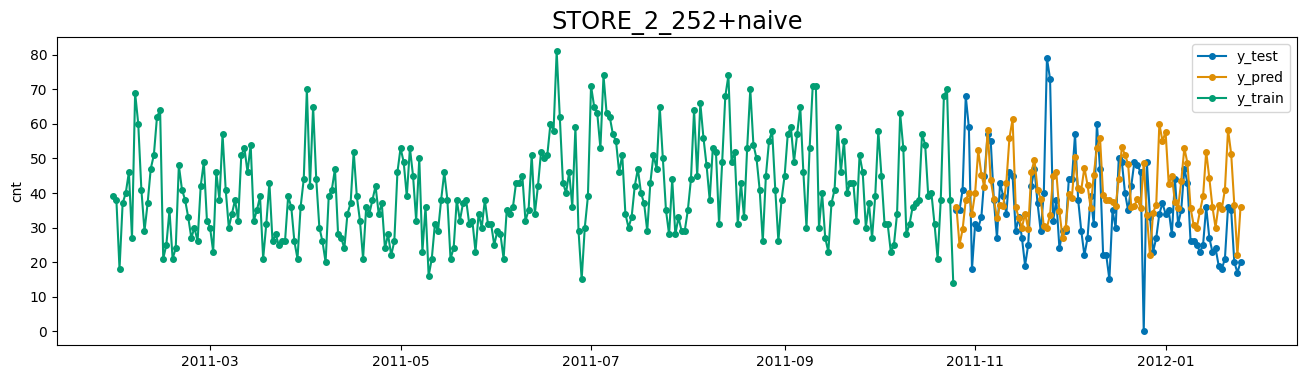

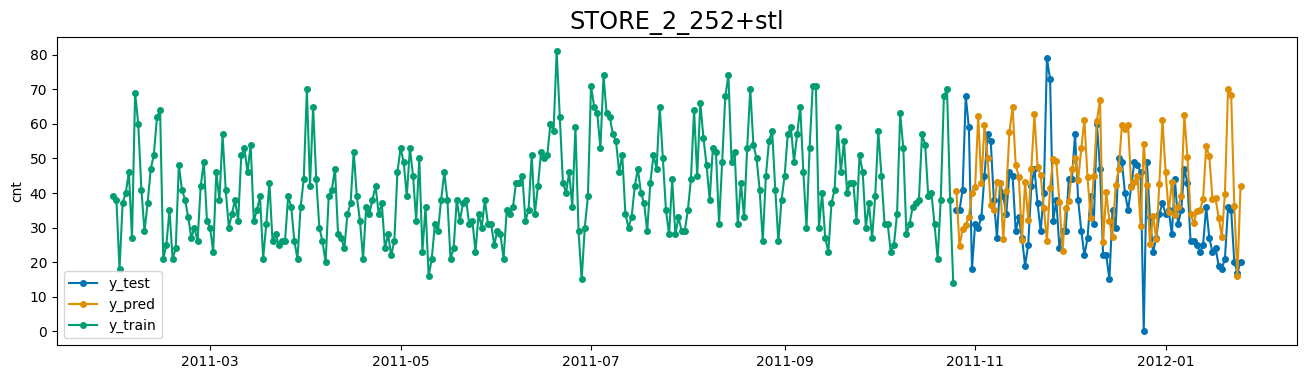

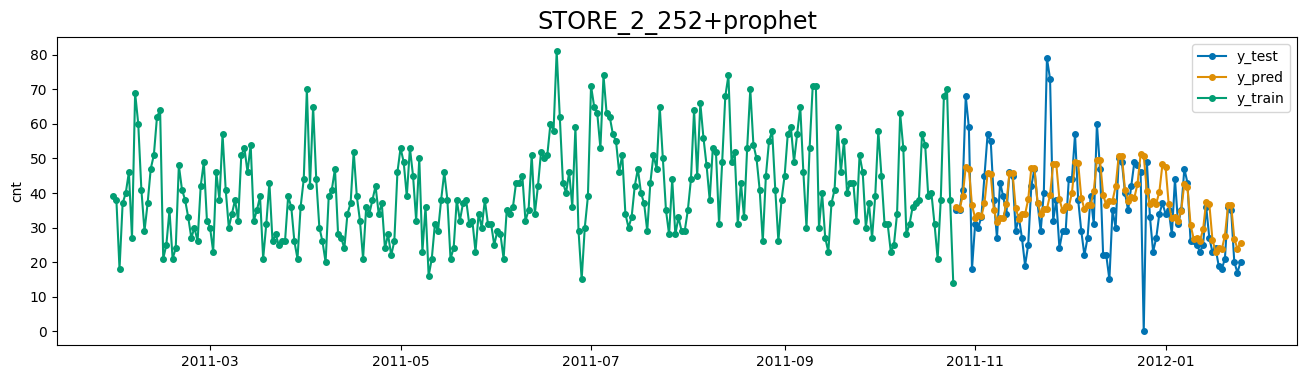

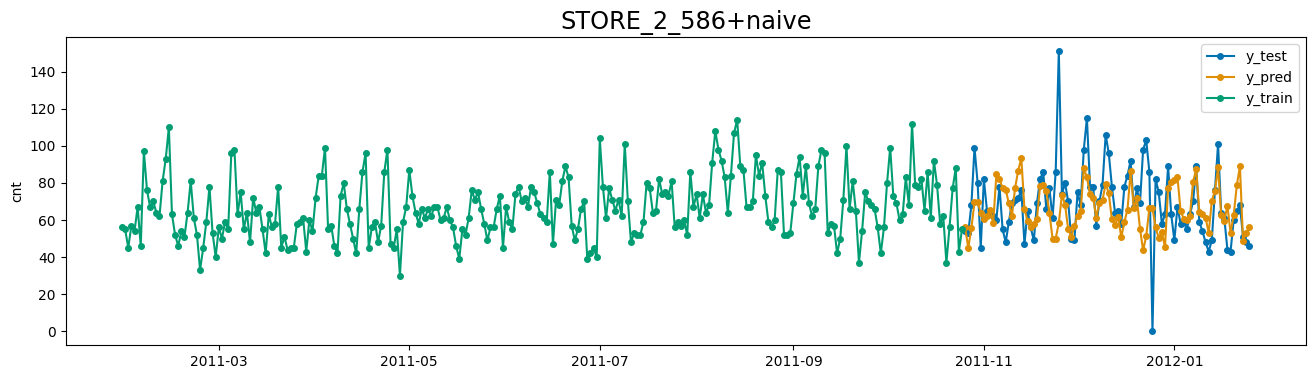

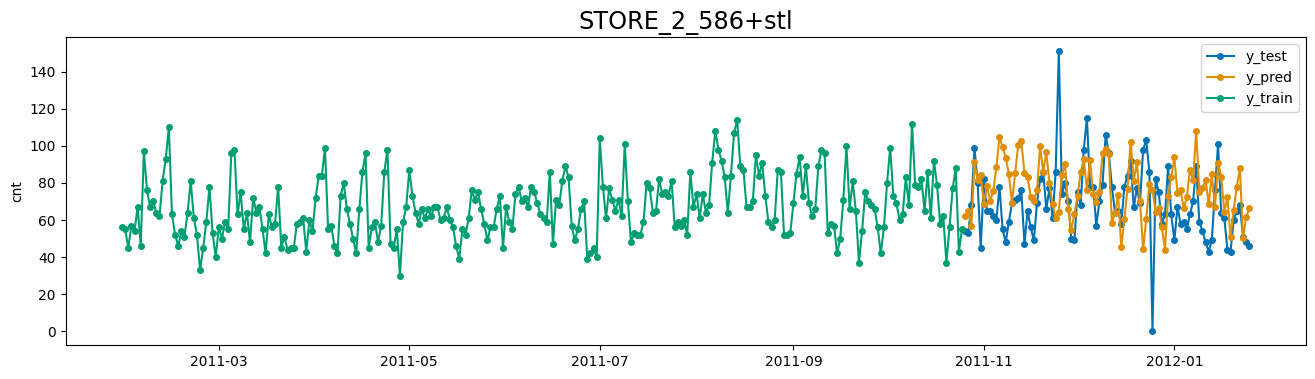

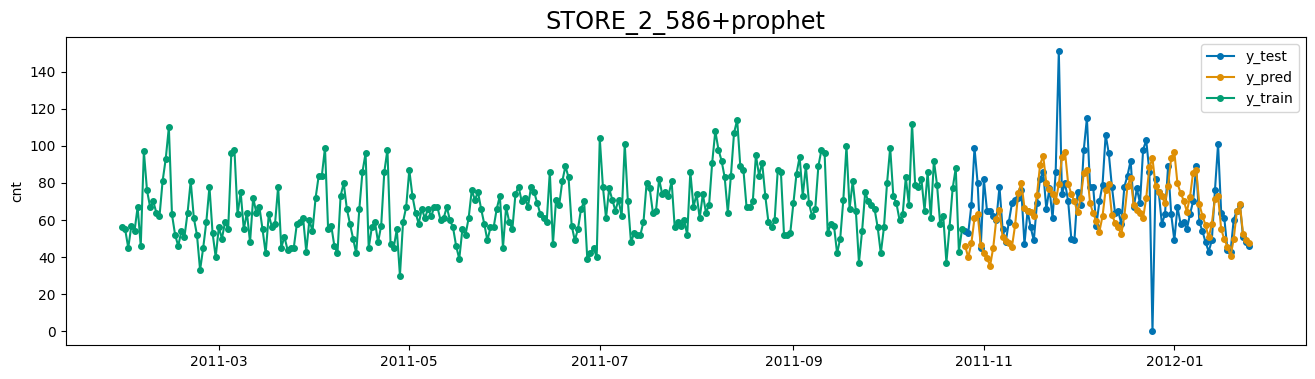

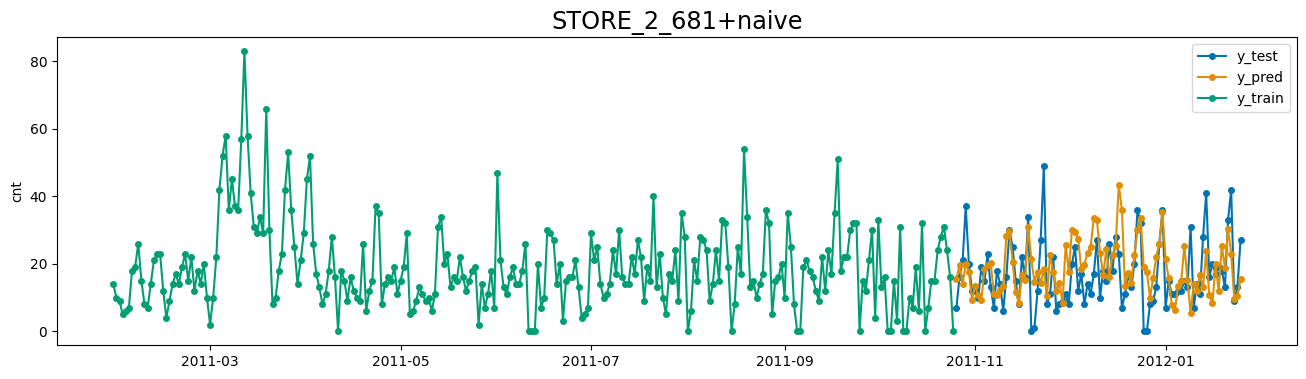

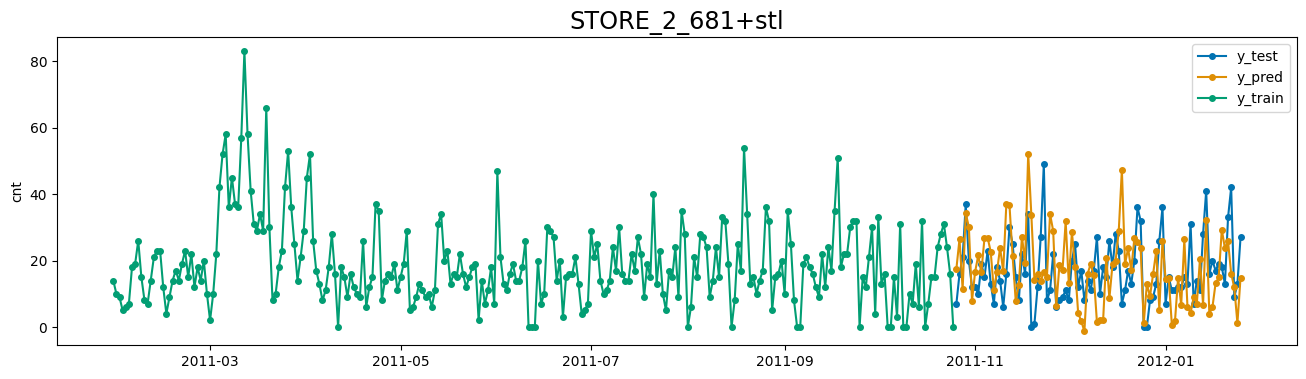

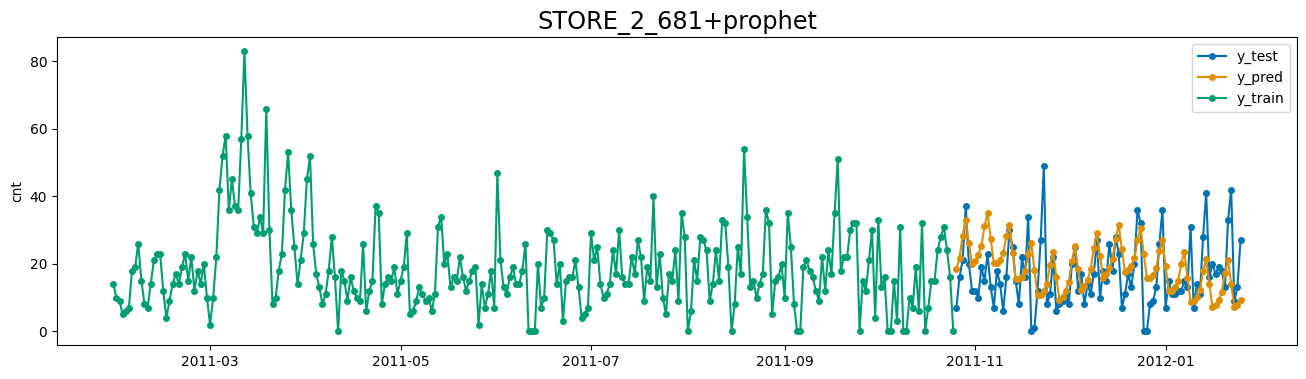

In [ ]:
s = Solution(store2, calendar, periods, models)
products_name = ['STORE_2_252', 'STORE_2_586', 'STORE_2_681']
s.preprocess_data()
for product in products_name:
    for model in models.keys():
        s.predict(product=product, period=92, model_name=model)

Проанализиуем полученные метрики. Период 7 дней: лучше всего метрика MAE у модели prophet, хуже всего на большинтсве товаров у STL; метрика MAPE по-разному. Период 30 дней: метрики MAE и MAPE в основном лучше у модели prophet, но не на данных, где практически не видно периодичности, на них лучше наивный прогноз, на данных, где есть длинные последовательности нулей, лучше работает модель STL. Период 92 дня: и по метрике MAE самые лучшие результаты дал наивный прогноз. Если посмотреть на построенные графики, то тоже можно увидеть, что на сезонных данных лучше всего работает модель prophet и naiv, а на данных без четкой структуры модель STL.

**Вывод:** prophet показал себя лучше других моделей на предсказаниии на недлительный период (7 дней). На более длительных периодах prophet хорошо работает только на данных с чётко выделенной сезонностью, а на данных без четкой структуры лучше STL. naiv тоже показывает довольно неплохие результаты на длительном периоде. Лучшая достигнутая метрика MAE = 0.648543, а лучшая метрика MAPE = 1.860501e-01, обе получены для предсказания на 7 дней модели prophet.